In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from pandas import DataFrame, Series
from sklearn import datasets
from matplotlib import pyplot as plt
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

plt.ioff()
pd.set_option('display.max_columns', None)  # Print all the columns in the dataframe
pd.set_option('display.expand_frame_repr', False)  # Prevents line breaks while printing the dataframe
mpl.rcParams['figure.figsize'] = (6*1.618, 6)

# Set the default resolution for plots on screen
display_res = (2560, 1440)  # Display resolution in pixels, h x v
diagonal_in = 27  # Display diagonal in inches
res_dpi = (display_res[0]**2 + display_res[1]**2) ** .5 / diagonal_in
plt.rcParams['figure.dpi'] = res_dpi

# By default, display grids in plot
mpl.rcParams['axes.grid'] = True

This is an exploration of linear regression, and different tools available to solve it with Python.
The dataset of choice is the [Boston Housing Prices](http://lib.stat.cmu.edu/datasets/boston)

Here for reference the meaning of the variables, taken from the [dataset description](https://bit.ly/3yqTZnL)
- CRIM - per capita crime rate by town
- ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS - proportion of non-retail business acres per town.
- CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- NOX - nitric oxides concentration (parts per 10 million)
- RM - average number of rooms per dwelling
- AGE - proportion of owner-occupied units built prior to 1940
- DIS - weighted distances to five Boston employment centres
- RAD - index of accessibility to radial highways
- TAX - full-value property-tax rate per $10,000
- PTRATIO - pupil-teacher ratio by town
- B - 1000(Bk - 0.63)\^2 where Bk is the proportion of blacks by town
- LSTAT - \% lower status of the population
- MEDV - Median value of owner-occupied homes in thousands USD


Feth the dataset from its original source, and load it.

In [20]:
with warnings.catch_warnings():
    # ignore all caught warnings
    warnings.filterwarnings("ignore")
    boston = datasets.load_boston()

"""
Dropping the 'B' variable from the dataset: it is a non-invertible variable engineered by the authors of the dataset;
it is not clear how to use it for the analysis to follow, whatever the usage intended by the dataset authors.
"""
columns = boston.feature_names[boston.feature_names != 'B']

"""
dataset_X => predictors
dataset_y => target variable
dataset => predictors and target variable
"""
dataset_X = DataFrame(boston.data, columns=boston.feature_names)
dataset_y = Series(boston.target)
dataset = dataset_X.copy()
dataset['MEDV'] = dataset_y  # Assign the correct name to the target variable

Compute and display some statistics from the dataset

In [21]:
n_samples = len(dataset)
n_vars = len(dataset.columns) - 1

print(f'The dataset contains {n_samples} samples, and {n_vars} variables (target not included).')

The dataset contains 506 samples, and 13 variables (target not included).


In [22]:
print('The first 5 samples from the dataset')
print(dataset.head())

The first 5 samples from the dataset
      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  PTRATIO       B  LSTAT  MEDV
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0     15.3  396.90   4.98  24.0
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0     17.8  396.90   9.14  21.6
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0     17.8  392.83   4.03  34.7
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0     18.7  394.63   2.94  33.4
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0     18.7  396.90   5.33  36.2


In [23]:
print('Dataset stats')
print(dataset.describe().T)

Dataset stats
         count        mean         std        min         25%        50%         75%       max
CRIM     506.0    3.613524    8.601545    0.00632    0.082045    0.25651    3.677083   88.9762
ZN       506.0   11.363636   23.322453    0.00000    0.000000    0.00000   12.500000  100.0000
INDUS    506.0   11.136779    6.860353    0.46000    5.190000    9.69000   18.100000   27.7400
CHAS     506.0    0.069170    0.253994    0.00000    0.000000    0.00000    0.000000    1.0000
NOX      506.0    0.554695    0.115878    0.38500    0.449000    0.53800    0.624000    0.8710
RM       506.0    6.284634    0.702617    3.56100    5.885500    6.20850    6.623500    8.7800
AGE      506.0   68.574901   28.148861    2.90000   45.025000   77.50000   94.075000  100.0000
DIS      506.0    3.795043    2.105710    1.12960    2.100175    3.20745    5.188425   12.1265
RAD      506.0    9.549407    8.707259    1.00000    4.000000    5.00000   24.000000   24.0000
TAX      506.0  408.237154  168.5371

In [24]:
print('Count of unique values for each variable')
counts = dataset.nunique()
print(counts.to_frame().T)

Count of unique values for each variable
   CRIM  ZN  INDUS  CHAS  NOX   RM  AGE  DIS  RAD  TAX  PTRATIO    B  LSTAT  MEDV
0   504  26     76     2   81  446  356  412    9   66       46  357    455   229


In [25]:
print('\nCount number of NaN for each variable')
print(dataset.isna().sum().to_frame().T)


Count number of NaN for each variable
   CRIM  ZN  INDUS  CHAS  NOX  RM  AGE  DIS  RAD  TAX  PTRATIO  B  LSTAT  MEDV
0     0   0      0     0    0   0    0    0    0    0        0  0      0     0


Draw box plots for every variable, side by side (each has its own scale)

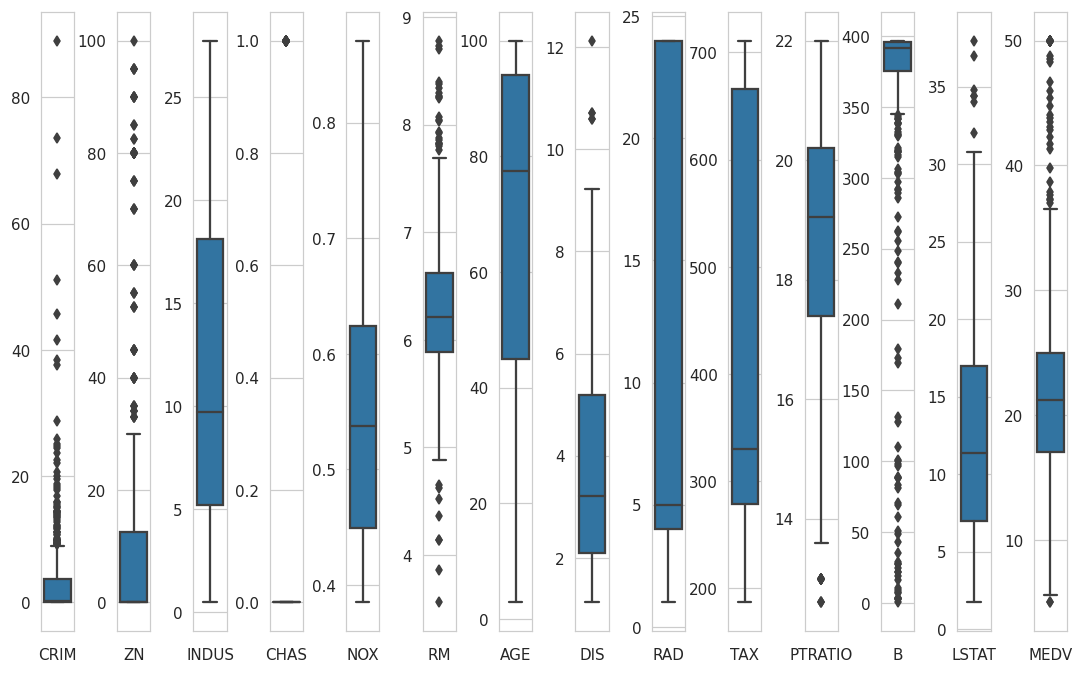

In [26]:
fig, axes = plt.subplots(1, n_vars + 1)
# fig.subplots_adjust(wspace=.25)
for i, col in enumerate(dataset.columns):
    bplot = sns.boxplot(y=dataset[col], ax=axes[i])
    bplot.set(ylabel=None)
    bplot.set(xlabel=col)
fig.tight_layout(pad=0, w_pad=.25, h_pad=0)

We start with a simple (that is, uni-variate) linear regression of MEDV against LSTAT.

Plotting the distribution of LSTAT values

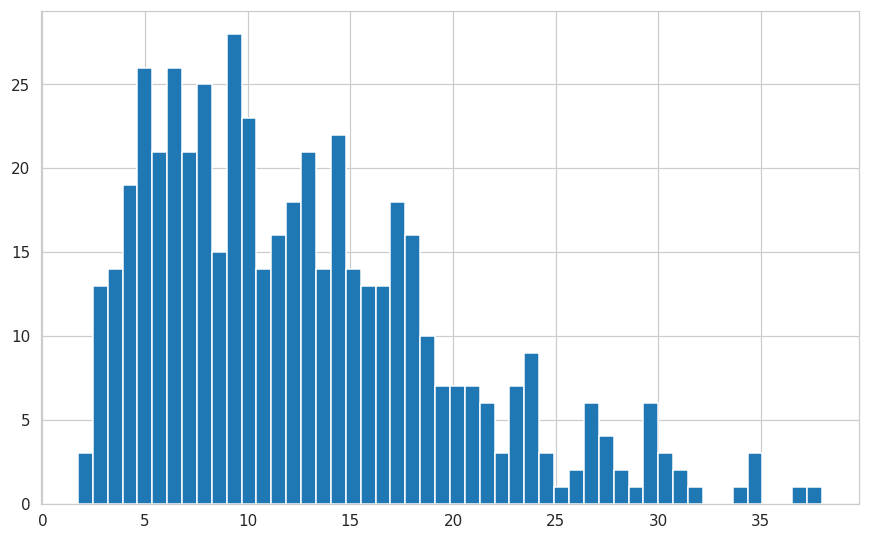

In [27]:
plt.hist(dataset['LSTAT'], bins=50);

Perform the simple linear regression of MEDV against LSTAT and output its stats.

In [28]:
X, y = dataset['LSTAT'].values.reshape(-1, 1), dataset['MEDV'].values
model: LinearRegression = LinearRegression().fit(X, y)
y_pred = model.predict(X=X)
slope = model.coef_[0]
intercept = model.intercept_
print(f'\nMEDV linear regression against LSTAT has coefficient (slope) {slope} and intercept {intercept}')
r2 = model.score(X, y)
rss = np.sum(np.power(y - y_pred, 2))
rse = (rss / (n_samples - 2)) ** .5
print(f'RSS={rss:.3f}; RSE={rse:.3f} on {n_samples - 2} degrees of freedom; R-squared={r2:.3f}')


MEDV linear regression against LSTAT has coefficient (slope) -0.9500493537579906 and intercept 34.5538408793831
RSS=19472.381; RSE=6.216 on 504 degrees of freedom; R-squared=0.544


Plot the linear regression against the data.

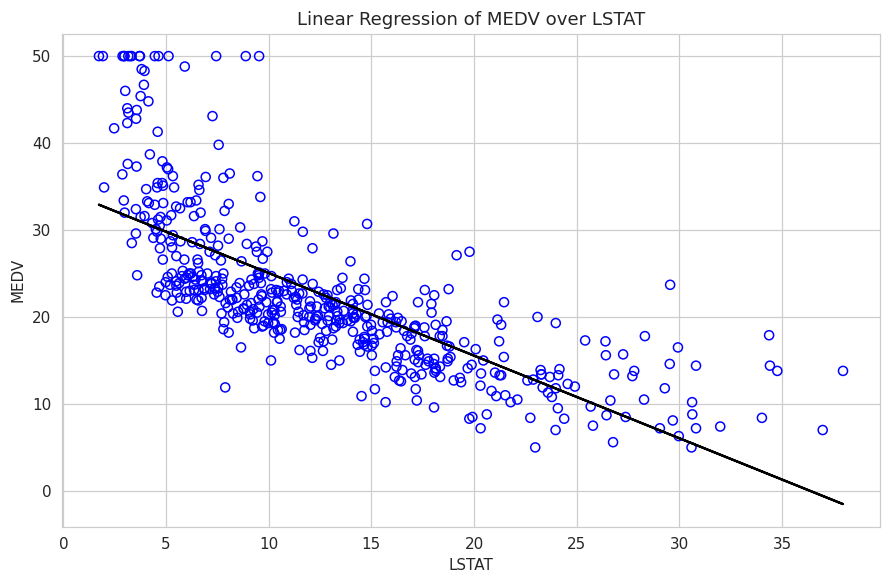

In [29]:
_, ax = plt.subplots()
ax.scatter(X, y, facecolor='none', edgecolor='blue')
ax.plot(X, y_pred, color='black')
ax.set_xlabel('LSTAT')
ax.set_ylabel('MEDV')
ax.set_title('Linear Regression of MEDV over LSTAT');

Is there a relationship between MEDV and LSTAT? The linear regression plot indicates so, in spite of outliers toward
high MEDV values; however, more formally, we want to test the null hypothesis:
    -There is no relationship between MEDV and LSTAT

The 95% confidence interval for the slope is [-1.028, -0.873]
The 95% confidence interval for the intercept is [33.429, 35.679]


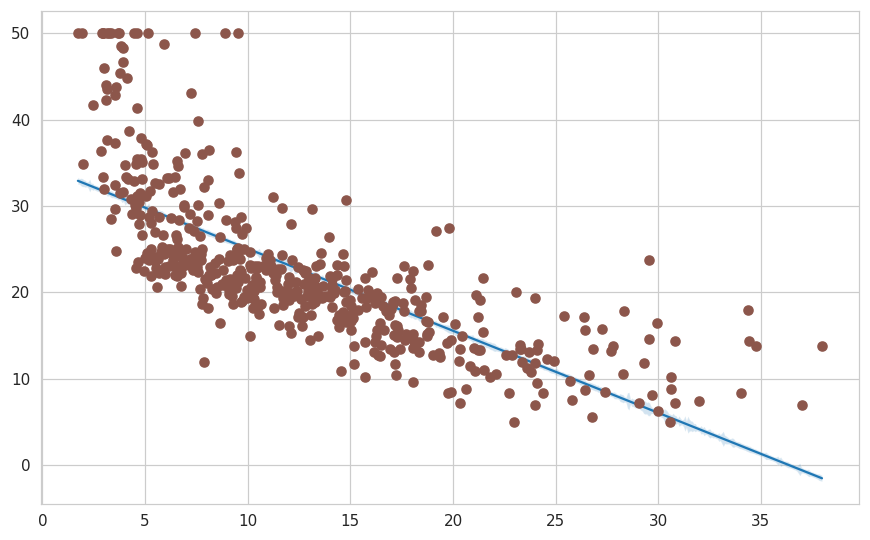

In [30]:
''' We can get a feeling for how accurate the estimate of slope and intercept are, by determining a confidence interval
for them '''
X_mean = np.mean(X)
se2_slope = rse ** 2 / np.sum(np.power(X - X_mean, 2))
se2_intercept = rse ** 2 * (1 / n_samples + X_mean ** 2 / np.sum(np.power(X - X_mean, 2)))
print(
    f'The 95% confidence interval for the slope is [{slope - 2 * se2_slope ** .5:.3f}, {slope + 2 * se2_slope ** .5:.3f}]')
print(
    f'The 95% confidence interval for the intercept is [{intercept - 2 * se2_intercept ** .5:.3f}, {intercept + 2 * se2_intercept ** .5:.3f}]')

x = np.linspace(np.min(X), np.max(X), n_samples)
y_est = slope * x + intercept
# y_err = x.std() * np.sqrt(1 / len(x) + (x - x.mean()) ** 2 / np.sum((x - x.mean()) ** 2))
y_err = rse * np.sqrt(1 / n_samples + (X - X_mean) ** 2 / np.sum((X - X_mean) ** 2))
y_err = y_err.squeeze()

_, ax = plt.subplots()
ax.plot(x, y_est, '-')
ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
ax.plot(X, y, 'o', color='tab:brown');

Let's do it again, this time with Statsmodel

In [31]:
X_exog = sm.add_constant(X, prepend=False)  # TODO this is needed for correct result, but why?
model2 = sm.OLS(y, X_exog)
res = model2.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Sun, 15 May 2022   Prob (F-statistic):           5.08e-88
Time:                        20:28:56   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.9500      0.039    -24.528      0.0

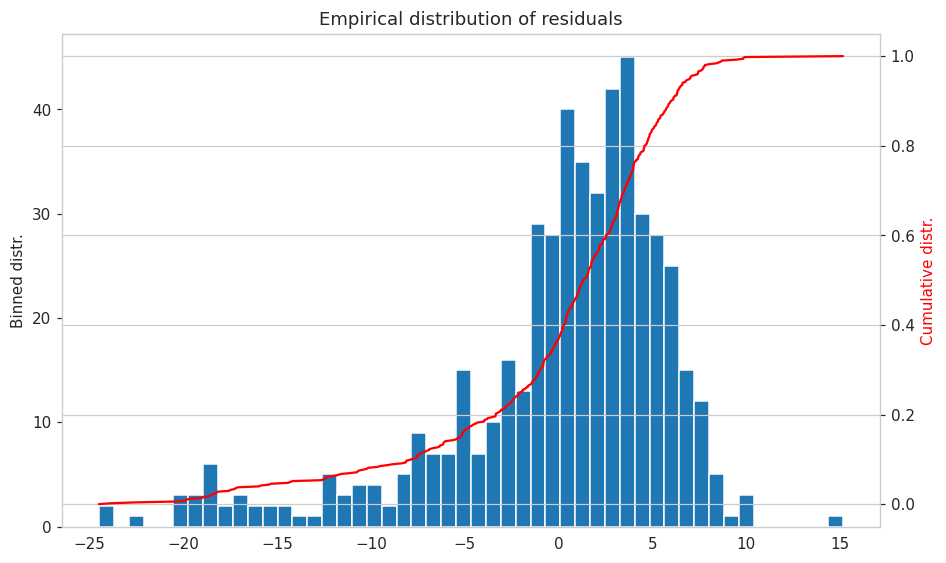

In [32]:
residuals = y_pred - y
_, ax = plt.subplots()
ax.set_title('Empirical distribution of residuals')
ax.set_ylabel('Binned distr.')
ax.hist(residuals, 50)
ax.grid(visible=False)
sorted_residuals = np.sort(residuals)
cum_prob = 1. * np.arange(len(sorted_residuals)) / float(len(sorted_residuals) - 1)
# prob_dens = cum_prob /
ax2 = ax.twinx()
ax2.set_ylabel('Cumulative distr.', color='red')
ax2.plot(sorted_residuals, cum_prob, color='red');

Now let's do some multi-variate regression

In [33]:
'''
TODO
- My confidence intervale is 95% instead of 97.5%, difficult to compare with those provided by R and Statsmodel;
also my CI seem inconsistent with those provided by R and Statsmodel
- Not clear how to compute and plot the bands of uncertainty around the linear regression, i.e. the CI for a given
inference; see y_err above
Note: se2_intercept and se2_slope appear to be correct when compared to R output
'''

'\nTODO\n- My confidence intervale is 95% instead of 97.5%, difficult to compare with those provided by R and Statsmodel;\nalso my CI seem inconsistent with those provided by R and Statsmodel\n- Not clear how to compute and plot the bands of uncertainty around the linear regression, i.e. the CI for a given\ninference; see y_err above\nNote: se2_intercept and se2_slope appear to be correct when compared to R output\n'

In [34]:
X, y = dataset_X, dataset_y
mv_model: LinearRegression = LinearRegression().fit(X, y)
coeffs = pd.Series(mv_model.coef_, index=mv_model.feature_names_in_)
print(f'\nCoefficients of multi-variate linear regression, with intercept {mv_model.intercept_:.6f}')
print(coeffs.to_frame().T)

y_pred = mv_model.predict(X)
mse = mean_squared_error(y, y_pred)

r2 = mv_model.score(X, y)
rss = np.sum(np.power(y - y_pred, 2))
rse = (rss / (n_samples - 2)) ** .5
print(f'RSS={rss:.3f}; RSE={rse:.3f} on {n_samples - 2} degrees of freedom; R-squared={r2:.3f}')
print('\nThe correlation matrix')
corr_matrix = dataset.corr()
print(corr_matrix)


Coefficients of multi-variate linear regression, with intercept 36.459488
       CRIM       ZN     INDUS      CHAS        NOX        RM       AGE       DIS       RAD       TAX   PTRATIO         B     LSTAT
0 -0.108011  0.04642  0.020559  2.686734 -17.766611  3.809865  0.000692 -1.475567  0.306049 -0.012335 -0.952747  0.009312 -0.524758
RSS=11078.785; RSE=4.688 on 504 degrees of freedom; R-squared=0.741

The correlation matrix
             CRIM        ZN     INDUS      CHAS       NOX        RM       AGE       DIS       RAD       TAX   PTRATIO         B     LSTAT      MEDV
CRIM     1.000000 -0.200469  0.406583 -0.055892  0.420972 -0.219247  0.352734 -0.379670  0.625505  0.582764  0.289946 -0.385064  0.455621 -0.388305
ZN      -0.200469  1.000000 -0.533828 -0.042697 -0.516604  0.311991 -0.569537  0.664408 -0.311948 -0.314563 -0.391679  0.175520 -0.412995  0.360445
INDUS    0.406583 -0.533828  1.000000  0.062938  0.763651 -0.391676  0.644779 -0.708027  0.595129  0.720760  0.383248 -0.3569

Display the correlation matrix as a heatmap with Seaborn

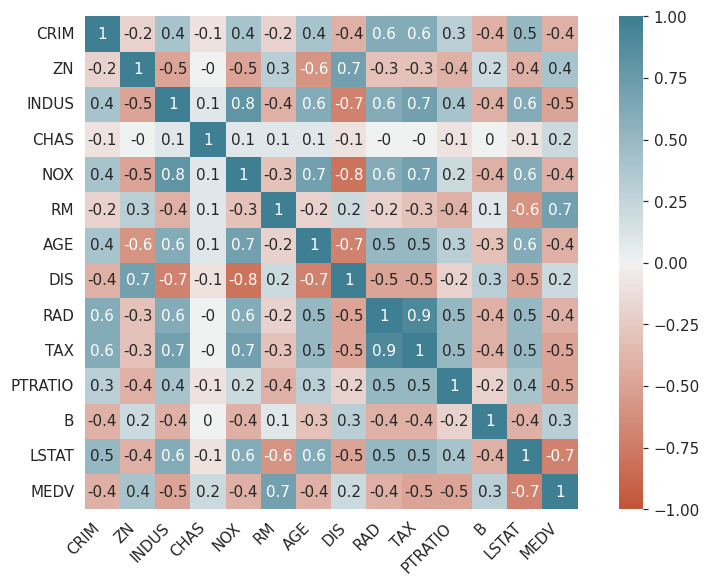

In [35]:
plt.subplots()
corr_matrix_rounded = corr_matrix.round(decimals=1)
ax = sns.heatmap(corr_matrix_rounded,
                 vmin=-1,
                 vmax=1,
                 center=0,
                 cmap=sns.diverging_palette(20, 220, n=200),
                 square=True,
                 annot=True)
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right');

Let's give it a spin with Statsmodel

In [36]:
print('\nSummary of multi-variate linear regression with Statsmodel')
X_exog = sm.add_constant(dataset_X, prepend=False)  # TODO this is needed for correct result, but why?
model2 = sm.OLS(dataset_y, X_exog)
res = model2.fit()
print('\n', res.summary())


Summary of multi-variate linear regression with Statsmodel

                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Sun, 15 May 2022   Prob (F-statistic):          6.72e-135
Time:                        20:28:56   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------